# Importing packages 

In [2]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

# Custom functions

In [ ]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

# Reading the data 

In [58]:
d = pd.read_csv('data/weather.csv')

print(f'Shape of data: {d.shape}')

Shape of data: (63729, 2)


In [59]:
# Types of columns
d.dtypes

Time         object
Channel A    object
dtype: object

In [60]:
# Converting the dt column to datetime object 
d['dt'] = [datetime.datetime.utcfromtimestamp(x) for x in d['dt']]

# Sorting by the date 
d.sort_values('dt', inplace=True)

KeyError: 'dt'

In [5]:
# Listing the min and the max dates 
print(f"First date {min(d['dt'])}")
print(f"Most recent date {max(d['dt'])}")

NameError: name 'd' is not defined

# Column explanations

The columns that will be used in the analysis:
    
* **dt** - local datetime of the observation 

* **date** - local date of the observation

* **temp** - the observed temperature in Celcius

* **pressure** -  Atmospheric pressure (on the sea level, if there is no sea_level or grnd_level data), hPa

* **clouds_all** - cloudiness in %. 

* **wind_speed** - speed of wind in meter/sec.  

* **humidity** - concentrantion of water vapor in the air.

# Data cleaning 

In [6]:
print(f"Total unique dates in the dataset: {len(set(d['dt']))}")

NameError: name 'd' is not defined

In [7]:
print(f"Number of rows in the dataset: {d.shape[0]}")

NameError: name 'd' is not defined

In [8]:
# Features used in models
features = ['temp', 'pressure', 'wind_speed']

# Aggregating to hourly level
d = d.groupby('dt', as_index=False)[features].mean()

# Creating the data column
d['date'] = [x.date() for x in d['dt']]

NameError: name 'd' is not defined

# Explanatory data analysis 

## Descriptive statistics

In [9]:
d[features].describe()

NameError: name 'd' is not defined

## Snapshot of temperature data 

In [10]:
d[['dt', 'temp']].head(10)

NameError: name 'd' is not defined

In [11]:
d[['dt', 'temp']].tail(10)

NameError: name 'd' is not defined

In [12]:
plt.figure(figsize=(12, 8))
plt.plot('dt', 'temp', data=d)
plt.title('Hourly temperature graph')
plt.ylabel('Degrees in C')
plt.xlabel('Date')
plt.show()

NameError: name 'd' is not defined

<Figure size 864x576 with 0 Axes>

## Hourly data plots

In [13]:
plot_features = d[features]
plot_features.index = d.dt

fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(['pressure', 'wind_speed']):
    axes[i % 2].plot(plot_features[feature])
    axes[i % 2].set_title(f'{feature} Vilnius - hourly')
        
plt.tight_layout()

plt.show()

NameError: name 'd' is not defined

## Daily data 

In [14]:
plot_features = d.groupby('date')[features].mean()

fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} Vilnius - daily')
        
plt.tight_layout()

plt.show()

NameError: name 'd' is not defined

## Heatmaps

In [15]:
plt.figure(figsize=(8, 8))
plt.hist2d(d['pressure'], d['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Pressure, hPa')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

NameError: name 'd' is not defined

<Figure size 576x576 with 0 Axes>

In [16]:
plt.figure(figsize=(8, 8))
plt.hist2d(d['wind_speed'], d['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Wind speed, m/s')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

NameError: name 'd' is not defined

<Figure size 576x576 with 0 Axes>

# Feature engineering

In [17]:
# Extracting the hour of day
d['hour'] = [x.hour for x in d['dt']]

# Extracting the month of the year 
d['month'] = [x.month for x in d['dt']]

NameError: name 'd' is not defined

In [18]:
d.boxplot('temp', by='hour', figsize=(12, 8), grid=False)

NameError: name 'd' is not defined

In [19]:
d.boxplot('temp', by='month', figsize=(12, 8), grid=False)

NameError: name 'd' is not defined

In [20]:
# Creating the cyclical daily feature 
d['day_cos'] = [np.cos(x * (2 * np.pi / 24)) for x in d['hour']]
d['day_sin'] = [np.sin(x * (2 * np.pi / 24)) for x in d['hour']]

NameError: name 'd' is not defined

In [21]:
dsin = d[['dt', 'temp', 'hour', 'day_sin', 'day_cos']].head(25).copy()
dsin['day_sin'] = [round(x, 3) for x in dsin['day_sin']]
dsin['day_cos'] = [round(x, 3) for x in dsin['day_cos']]

dsin

NameError: name 'd' is not defined

In [22]:
# Ploting the first 25 hours 
plt.plot(np.array(d['day_cos'])[:25], label='cos')
plt.plot(np.array(d['day_sin'])[:25], label='sin')
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.legend()
plt.show()

NameError: name 'd' is not defined

In [23]:
# Extracting the timestamp from the datetime object 
d['timestamp'] = [x.timestamp() for x in d['dt']]

# Seconds in day 
s = 24 * 60 * 60 

# Seconds in year 
year = (365.25) * s

d['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in d['timestamp']]
d['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in d['timestamp']]

NameError: name 'd' is not defined

In [24]:
# Ploting the first year
plt.plot(np.array(d['month_cos'])[:24 * 365])
plt.plot(np.array(d['month_sin'])[:24 * 365])
plt.xlabel('Time [h]')
plt.title('Time of year signal')
plt.show()

NameError: name 'd' is not defined

# Single step forecast

## Hyper parameters

In [25]:
# Number of lags (hours back) to use for models
lag = 48

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

# The features used in the modeling 
features_final = ['temp', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'pressure', 'wind_speed']

## Creating the matrices for training

In [26]:
d[features_final].head(10)

NameError: name 'd' is not defined

In [27]:
# Subseting only the needed columns 
ts = d[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

NameError: name 'd' is not defined

In [28]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

NameError: name 'create_X_Y' is not defined

In [29]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

NameError: name 'X' is not defined

In [30]:
print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

NameError: name 'Xtrain' is not defined

# Defining the model 

In [31]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [32]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

NameError: name 'Xtrain' is not defined

In [33]:
model.model.summary()

NameError: name 'model' is not defined

In [34]:
history = model.train()

NameError: name 'model' is not defined

In [35]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

NameError: name 'history' is not defined

In [36]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

NameError: name 'model' is not defined

In [37]:
# Creating the frame to store both predictions
days = d['dt'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

NameError: name 'd' is not defined

In [38]:
pivoted.tail(10)

NameError: name 'pivoted' is not defined

In [39]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - scaled data')
plt.legend()
plt.show()

NameError: name 'pivoted' is not defined

<Figure size 864x864 with 0 Axes>

In [40]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - absolute data')
plt.legend()
plt.show()

NameError: name 'pivoted' is not defined

<Figure size 864x864 with 0 Axes>

In [41]:
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

NameError: name 'frame' is not defined

In [42]:
pivoted.tail(10)

NameError: name 'pivoted' is not defined

In [43]:
print(f"Average absolute mean error: {round(pivoted['res_abs'].sum() / pivoted.shape[0], 2)} C")

NameError: name 'pivoted' is not defined

In [44]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res, bins=40, edgecolor='black')
plt.title('Distribution of errors')
plt.show()

NameError: name 'pivoted' is not defined

<Figure size 864x576 with 0 Axes>

In [45]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res_abs, bins=40, edgecolor='black')
plt.title('Distribution of absolute errors')
plt.show()

NameError: name 'pivoted' is not defined

<Figure size 864x576 with 0 Axes>

In [46]:
pivoted.res_abs.describe()

NameError: name 'pivoted' is not defined

# Sequence prediction 

In [47]:
# Number of lags (hours back) to use for models
lag = 168

# Steps ahead to forecast 
n_ahead = 24

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

In [48]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

NameError: name 'create_X_Y' is not defined

In [49]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

NameError: name 'X' is not defined

In [50]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

NameError: name 'Xtrain' is not defined

In [51]:
model.model.summary()

NameError: name 'model' is not defined

In [52]:
history = model.train()

NameError: name 'model' is not defined

In [53]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

NameError: name 'history' is not defined

In [54]:
# Forecasting on all the samples in the validation set 
forecast = model.predict(Xval)

NameError: name 'model' is not defined

NameError: name 'forecast' is not defined

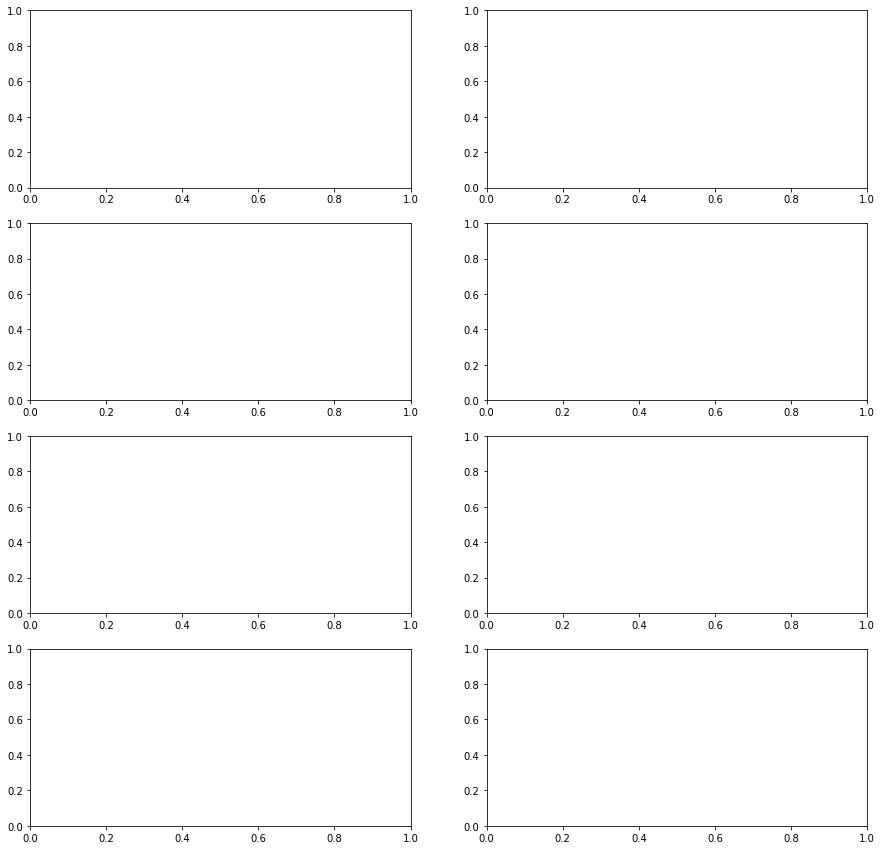

In [55]:
fig, axes = plt.subplots(
    nrows=4, 
    ncols=2, 
    figsize=(15, 15), 
    facecolor="w", 
    edgecolor="k"
)

indexes = random.sample(range(len(forecast)), 8)

for i, index in enumerate(indexes):
    
    yhat = forecast[index]
    y = Yval[index]

    frame = pd.concat([
        pd.DataFrame({'day': range(len(y)), 'temp': y, 'type': 'original'}),
        pd.DataFrame({'day': range(len(y)), 'temp': yhat, 'type': 'forecast'})
    ])
    
    frame['temp'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]
    
    sns.lineplot(x='day', y='temp', ax = axes[i // 2, i % 2], data=frame, hue='type', marker='o')
        
plt.tight_layout()

plt.show()

In [ ]:
# Calculating the total average absolute error 
error = 0 
n = 0
residuals = []

for i in range(Yval.shape[0]):
    true = Yval[i]
    hat = forecast[i]
    n += len(true)
    
    true = np.asarray([(x * train_std['temp']) + train_mean['temp'] for x in true])
    hat = np.asarray([(x * train_std['temp']) + train_mean['temp'] for x in hat])
    
    residual = true - hat
    residuals.append(residual)
    
    error += np.sum([abs(x) for x in true - hat]) 

print(f'Final average absolute error: {round(error / n, 2)} C')

In [ ]:
# Flattening the list of arrays of residuals
residuals = np.asarray(residuals).flatten().tolist()
abs_residuals = [abs(x) for x in residuals]

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=40, edgecolor='black')
plt.title('Distribution of errors - 24 hour forecast')
plt.show()

In [56]:
plt.figure(figsize=(12, 8))
plt.hist(abs_residuals, bins=40, edgecolor='black')
plt.title('Distribution of errors - 24 hour forecast - absolute')
plt.show()

NameError: name 'abs_residuals' is not defined

<Figure size 864x576 with 0 Axes>

In [57]:
print(f"Median absoulte error: {round(np.median(abs_residuals), 2)} C")

NameError: name 'abs_residuals' is not defined